# Clasificacion supervisada

In [9]:
#install.packages("dplyr",lib = r"(C:\Program Files\R\R-4.2.3\library)")

In [2]:
# Activar libreria
library(sp)
library(rgdal)
library(raster)
library(dplyr)
#library(e1071) # SVM Y Bayes
library(randomForest) # RandomForest
#library(rpart) # Decision Tree
#library(nnet) # Neural Network
library(snow)

In [3]:
# Cambiar directorio
setwd(r"(C:\Users\AGPRES\INIA_Pucallpa\Contrato_3\Investigacion\03_Suelo_Teledeteccion\Satelite\PUCALLPA\Sentinel2)")

In [4]:
# Crear lista del directorio
lista_datos <- list.files(path = getwd(), pattern = '.*tif$')
lista_datos

[1] "PUCALLPA_S2_20211022T151709_RS.tif"

In [5]:
# Agregar raster multibandas
S2 <- stack(lista_datos)

In [8]:
name_tif = c("B1","B2","B3","B4","B5","B6","B7","B8","B9","B11","B12")

In [9]:
# cambiar nombre de las bandas
names(S2) <- name_tif

In [10]:
names(S2)

[1] "B1"  "B2"  "B3"  "B4"  "B5"  "B6"  "B7"  "B8"  "B9"  "B11" "B12"

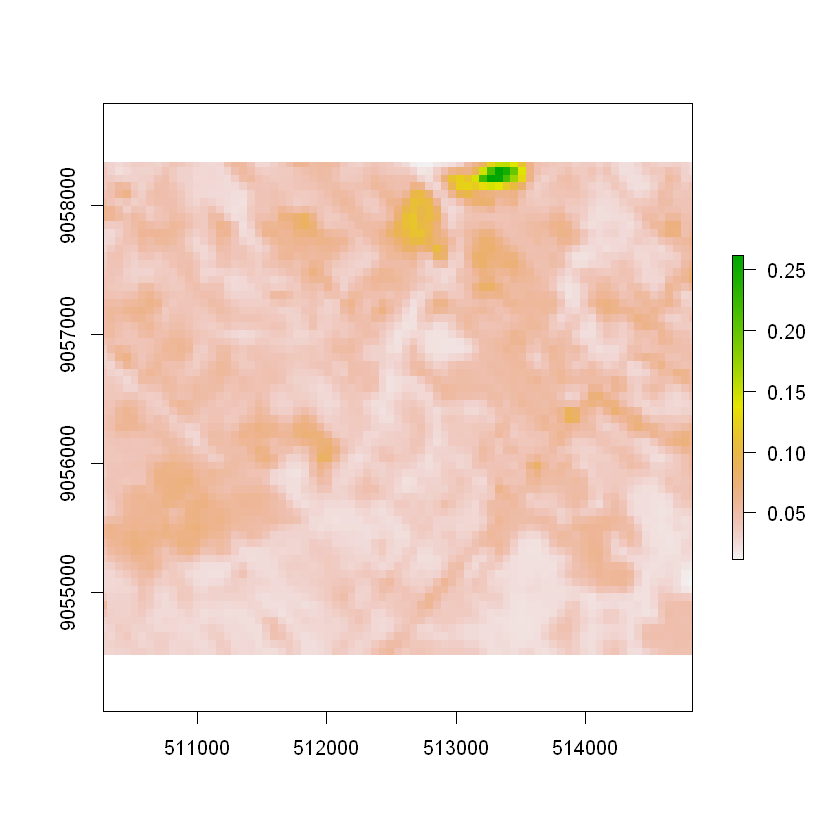

In [11]:
plot(S2[[1]])

In [12]:
# Agregar los shapefile del ROI
# Rura del shp
ROI <- shapefile(r"(C:\Users\AGPRES\INIA_Pucallpa\Contrato_3\Investigacion\03_Suelo_Teledeteccion\shp\ROI_S2.shp)")

In [13]:
# Informacion de la tabla de atributo del shp
head(ROI@data,10)

,Id,Uso
,<int>,<chr>
1,1,Bosque
2,1,Bosque
3,1,Bosque
4,1,Bosque
5,1,Bosque
6,1,Bosque
7,1,Bosque
8,1,Bosque
9,1,Bosque


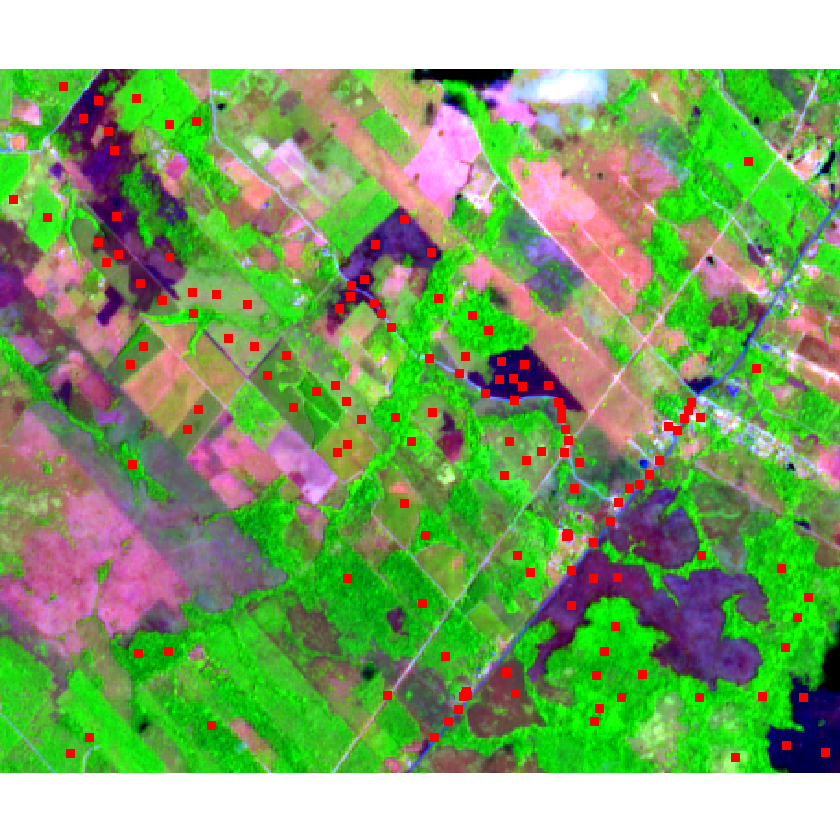

In [14]:
# Ploteamos la imagen y las puntos de muestreo
plotRGB(S2,10,8,2, stretch="lin")
plot(ROI,add=TRUE,col="red",pch = 15, lwd=3)

In [15]:
# Extraer los valores del raster a tabla
Extraer_RS <- extract(S2,ROI) # tenemos los valores Reflectancia Superficie
head(Extraer_RS)

B1,B2,B3,B4,B5,B6,B7,B8,B9,B11,B12
0.0195,0.0211,0.0413,0.0216,0.0770,0.2595,0.3277,0.2984,0.3542,0.1840,0.0836
0.0200,0.0251,0.0496,0.0233,0.0822,0.2872,0.3680,0.3728,0.3839,0.1889,0.0802
0.0214,0.0243,0.0496,0.0203,0.0821,0.2910,0.3570,0.3698,0.3892,0.1787,0.0739
0.0227,0.0283,0.0509,0.0279,0.0874,0.2583,0.3048,0.3168,0.3727,0.1844,0.0845
0.0287,0.0267,0.0495,0.0281,0.0840,0.2797,0.3654,0.3584,0.3443,0.2174,0.0974
0.0208,0.0229,0.0420,0.0180,0.0792,0.2845,0.3821,0.3453,0.3768,0.1870,0.0743


In [16]:
# Verificar si hay valores nulos
Nulos <- unlist(lapply(Extraer_RS,is.null))
Datos <- length(Nulos[Nulos==TRUE])

In [17]:
# Seleccionar clase
Class <- ROI@data$Id

In [20]:
# Descripcion de cobertura
unico_cobertura <- unique(ROI$Uso)
unico_clase <- unique(ROI$Id)

In [21]:
datos_clases <- data.frame(unico_cobertura, unico_clase)
datos_clases_ordenar <- arrange(datos_clases,unico_clase)

In [22]:
Cobertura <- datos_clases_ordenar$unico_cobertura

In [23]:
# Convertir dataframe
Tabla_cobertura <- data.frame(Extraer_RS,Class)
head(Tabla_cobertura)

,B1,B2,B3,B4,B5,B6,B7,B8,B9,B11,B12,Class
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,0.0195,0.0211,0.0413,0.0216,0.0770,0.2595,0.3277,0.2984,0.3542,0.1840,0.0836,1
2,0.0200,0.0251,0.0496,0.0233,0.0822,0.2872,0.3680,0.3728,0.3839,0.1889,0.0802,1
3,0.0214,0.0243,0.0496,0.0203,0.0821,0.2910,0.3570,0.3698,0.3892,0.1787,0.0739,1
4,0.0227,0.0283,0.0509,0.0279,0.0874,0.2583,0.3048,0.3168,0.3727,0.1844,0.0845,1
5,0.0287,0.0267,0.0495,0.0281,0.0840,0.2797,0.3654,0.3584,0.3443,0.2174,0.0974,1
6,0.0208,0.0229,0.0420,0.0180,0.0792,0.2845,0.3821,0.3453,0.3768,0.1870,0.0743,1


In [24]:
# Porcentaje de validacion
Porcentaje_validacion <- 0.2
Numero_Validacion <- nrow(Tabla_cobertura)*Porcentaje_validacion

In [25]:
# Seperando los datos en Entrenamiento y Validacion
Muestra <- sample(1:nrow(Tabla_cobertura),Numero_Validacion) # sample separa aleatoriamente los datos
Validacion <- Tabla_cobertura[Muestra,] # Validacion
Entrenamiento <- Tabla_cobertura[-Muestra,]
head(Entrenamiento)

,B1,B2,B3,B4,B5,B6,B7,B8,B9,B11,B12,Class
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,0.0195,0.0211,0.0413,0.0216,0.0770,0.2595,0.3277,0.2984,0.3542,0.1840,0.0836,1
2,0.0200,0.0251,0.0496,0.0233,0.0822,0.2872,0.3680,0.3728,0.3839,0.1889,0.0802,1
3,0.0214,0.0243,0.0496,0.0203,0.0821,0.2910,0.3570,0.3698,0.3892,0.1787,0.0739,1
4,0.0227,0.0283,0.0509,0.0279,0.0874,0.2583,0.3048,0.3168,0.3727,0.1844,0.0845,1
5,0.0287,0.0267,0.0495,0.0281,0.0840,0.2797,0.3654,0.3584,0.3443,0.2174,0.0974,1
6,0.0208,0.0229,0.0420,0.0180,0.0792,0.2845,0.3821,0.3453,0.3768,0.1870,0.0743,1


In [26]:
# Se convierte la variable respuesta a factor
Entrenamiento$Class <- as.factor(Entrenamiento$Class)

In [27]:
# Entrenamiento del modelo randomForest
modelo_rf <- randomForest(Class~., data = Entrenamiento, importance = T)
print(modelo_rf)


Call:
 randomForest(formula = Class ~ ., data = Entrenamiento, importance = T) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 3

        OOB estimate of  error rate: 3.6%
Confusion matrix:
   1  2  3  4 class.error
1 31  0  0  0  0.00000000
2  0 25  1  0  0.03846154
3  0  0 17  2  0.10526316
4  1  0  0 34  0.02857143


In [28]:
# configurar el objeto de claster para computacion paralela
beginCluster()

16 cores detected, using 15



In [30]:
# Determinacion del raster clasificacion del metodo 
clasificacion_rf <- clusterR(S2, raster::predict,args = list(model = modelo_rf))

In [31]:
endCluster()

In [34]:
# Definimos la paleta de colores segun las 4 clases
mycolor <- c("green", # Bosque
             "#0000FF", # Agua
             "", # Pastizal
             "#FF1493") # Quema

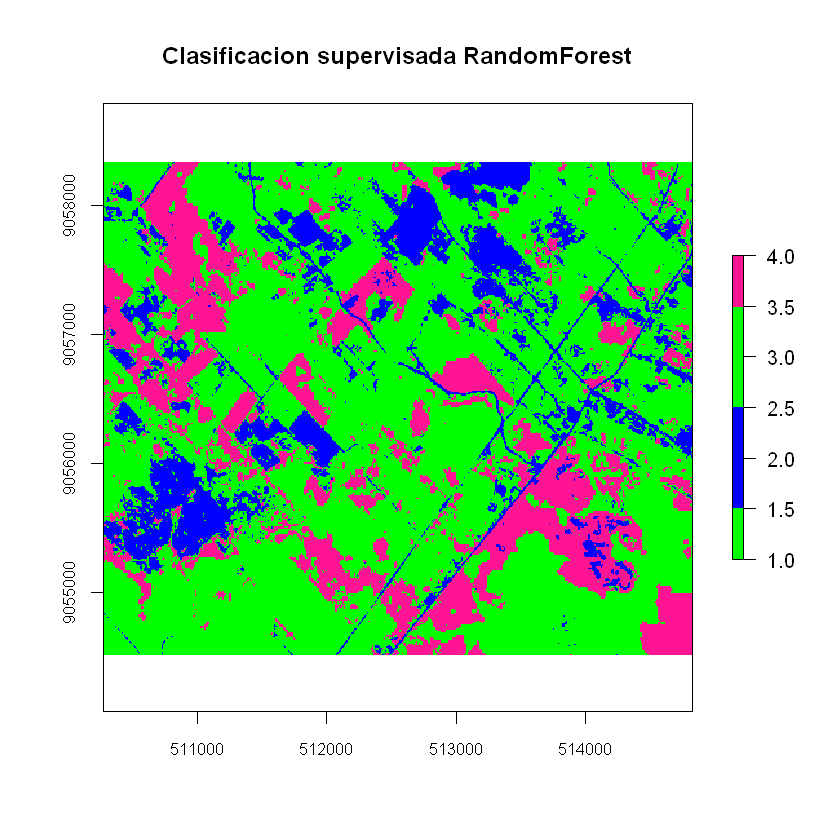

In [36]:
# Ploteamos la clasificacion con RandomForest
plot(clasificacion_rf, main="Clasificacion supervisada RandomForest",
     col = mycolor, cex.lab=0.8, cex.axis=0.8, cex.main=1.2)

In [37]:
#####################################################################################
# Prediccion segun el modelo
predicciones <- predict(object = modelo_rf, newdata = Validacion)
summary(predicciones)

1  2  3  4 
 8 12  3  4

In [40]:
Validacion

,B1,B2,B3,B4,B5,B6,B7,B8,B9,B11,B12,Class
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
42,0.0648,0.0859,0.1192,0.0929,0.1534,0.1804,0.2137,0.1582,0.3212,0.3032,0.2531,2
88,0.0301,0.0359,0.0619,0.0422,0.1089,0.2658,0.3283,0.3140,0.3554,0.2457,0.1244,3
46,0.0800,0.1982,0.2608,0.3488,0.4070,0.4116,0.4334,0.4040,0.3593,0.4443,0.4173,2
44,0.0648,0.0997,0.1426,0.0985,0.1477,0.1553,0.1929,0.1606,0.3212,0.3096,0.2593,2
113,0.0375,0.0457,0.0627,0.0743,0.1132,0.1973,0.2404,0.2437,0.2658,0.2660,0.1560,4
11,0.0213,0.0250,0.0491,0.0225,0.0825,0.3003,0.4010,0.3694,0.3932,0.1905,0.0792,1
81,0.0365,0.0504,0.0838,0.0886,0.1447,0.2416,0.2843,0.2774,0.3175,0.3010,0.1776,3
75,0.0424,0.0918,0.1150,0.1202,0.1441,0.1862,0.2149,0.2056,0.2438,0.2807,0.2016,2
78,0.0395,0.0528,0.0834,0.0800,0.1386,0.2300,0.2658,0.2613,0.3236,0.2722,0.1552,3


In [41]:
Validacion[,12]

[1] 2 3 2 2 4 1 3 2 3 2 4 3 1 1 2 2 4 2 1 1 1 2 2 2 1 4 2

In [42]:
# Determinacion del indice de kappa de la clasificacion
Matriz_confusion <- table(Validacion[,12],predicciones)
print(Matriz_confusion)

   predicciones
     1  2  3  4
  1  7  0  0  0
  2  0 12  0  0
  3  1  0  3  0
  4  0  0  0  4


In [43]:
colnames(Matriz_confusion)

[1] "1" "2" "3" "4"

In [44]:
rownames(Matriz_confusion)

[1] "1" "2" "3" "4"

In [45]:
colnames(Matriz_confusion) <- Cobertura
rownames(Matriz_confusion) <- Cobertura

In [46]:
# Exactitud Kappa
kappa = sum(diag(Matriz_confusion))/sum(Matriz_confusion)
print(kappa)

[1] 0.962963


In [49]:
####################################################################################
# Determinar area m2 y hectarea por clase
tbl <- rasterToPoints(clasificacion_rf, spatial = F)

In [50]:
tabla <- as.data.frame(tbl)
names(tabla) <- c("x", "y", "clase") # clase 1 al 5

In [51]:
# Sumatoria
conteo_tabla <- summarise(group_by(tabla, clase),count = n())

In [53]:
# Pixel a hectarea, mutate agregar nuevas columnas
Datos_area <- mutate(conteo_tabla, metros = count*xres(clasificacion_rf)^2, 
                     hectareas = metros/10000,porcentaje = (hectareas/sum(hectareas))*100)

In [54]:
# Crear una columna descripcion clase
Datos_area_clase <- cbind(Cobertura,Datos_area)

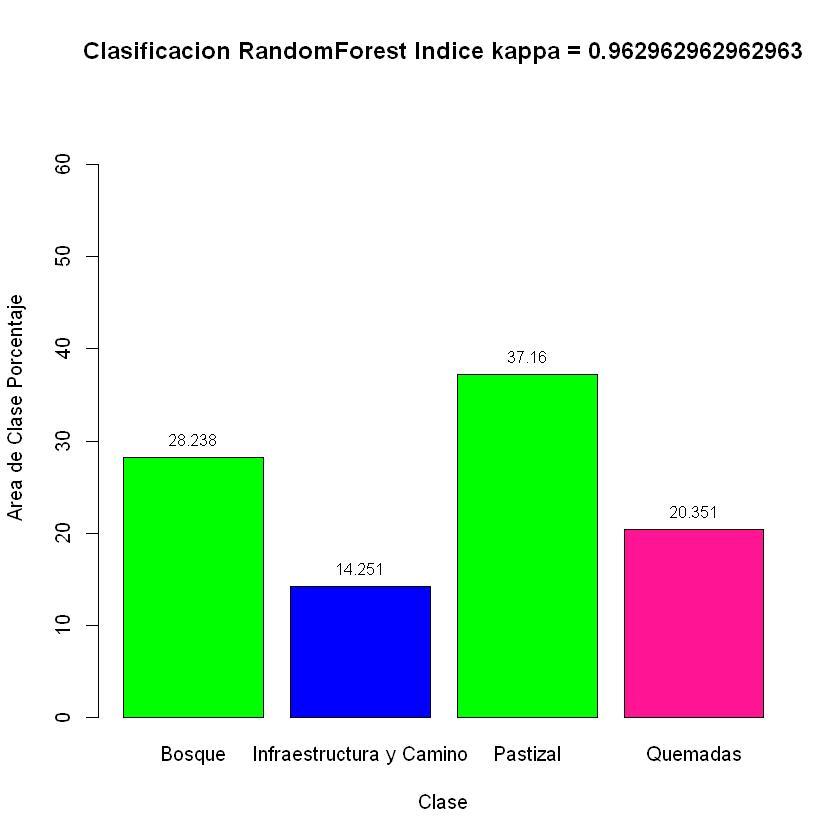

In [55]:
barra <- barplot(Datos_area_clase$porcentaje, 
                 col = mycolor, 
                 names.arg = Datos_area_clase$Cobertura,
                 main = paste("Clasificacion RandomForest Indice kappa = ",kappa, sep =""),
                 xlab = "Clase", 
                 ylab = "Area de Clase Porcentaje",
                 ylim=c(0, max(Datos_area_clase$porcentaje)+30))
text(x=barra, y=Datos_area_clase$porcentaje, pos=3, cex=0.8,
     label=round(Datos_area_clase$porcentaje, 3))

In [56]:
getwd()

[1] "C:/Users/AGPRES/INIA_Pucallpa/Contrato_3/Investigacion/03_Suelo_Teledeteccion/Satelite/PUCALLPA/Sentinel2"

In [58]:
# Exportacion de bandas y tablas
writeRaster(clasificacion_rf,"S2_RandomForest.tif", drivername="Gtiff")

In [59]:
write.csv(Matriz_confusion, file = "Matriz_confusion_RandomForest.csv", 
          row.names = T)

In [60]:
write.csv(Validacion, file = "Validacion_RandomForest.csv", 
          row.names = T)

In [61]:
write.csv(Entrenamiento, file = "Entrenamiento_RandomForest.csv", 
          row.names = T)

In [62]:
write.csv(Datos_area_clase, file = "Datos_area_clase_RandomForest.csv", 
          row.names = T)